#Part 1. n-Gram Language Models (30 points)

Create 1-5-gram language models trained on the tiny shakespeare dataset. The relevant probabilities P(word|context) will be stored in Python dictionaries. Do not use any smoothing or back-off (until Question 4). Pay special attention to beginning and end of sequences in the modeling process.

In this section, you may only use libraries imported in the original template.

In [1]:
# Import Libaries
import requests
import collections
import random
import math

In [2]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
response.raise_for_status() # Raise an exception for invalid HTTP status codes
text_data = response.text
len(text_data), text_data[:100]

(1115394,
 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou')

In [3]:
# sample
random.seed(42)

pos = random.randint(0, len(text_data) - 1000)
print(text_data[pos:pos+100])

BY:
Many good morrows to my noble lord!

HASTINGS:
Good morrow, Catesby; you are early stirring
What


In [4]:
# preprocessing - do not change
def preprocess_text(text_data):
  text_data = text_data.replace(',',' , ').replace(';', ' ').replace(':', ' ').replace('.',' . ').replace('?',' ? ').replace('!',' ! ')
  text_data = text_data.replace('-', ' ')
  text_data = text_data.replace('\'', '').replace('"', '')
  text_data = text_data.replace('  ', ' ')
  text_data = text_data.replace('\n\n','\n').replace('\n',' </s> <s> ')
  text_data = '<s> ' + text_data + ' </s>'
  text_data = text_data.lower()
  return text_data

text_data = preprocess_text(response.text)
print(f"Number of words: {len(text_data.split(' '))}")

Number of words: 328097


In [5]:
train_data = text_data[:-10_000]
test_data = text_data[-10_000:]
len(train_data), len(test_data)

(1431030, 10000)

In [6]:
vocab = set(train_data.split(' '))
print(f"Number of unique words: {len(vocab)}")
print(f"Sample unique words: {list(vocab)[:10]}")

Number of unique words: 12124
Sample unique words: ['', 'instantly', 'coral', 'sweet', 'fair', 'tames', 'disprove', 'unconstant', 'disbursed', 'griping']


 ## A. Dealing with Out of Vocabulary Words  (5 Points)

We want a way to handle words that did not appear in the train set. Create a list of out of vocabulary words by identifying words that appear in the train dataset less than 3 times.

**Hint:** You can split the dataset into terms by using corpus.split(' '). You can assume the results will be valid word tokens. No more preprocessing is necessary.

In [7]:
def identify_oov_words(corpus, n=3):
    """
    Identify out-of-vocabulary (OOV) words that appear less than `n` times in the dataset.

    Parameters:
    - dataset: The dataset to process. It should be a dictionary with a 'text' key.
    - n: The frequency threshold below which words are considered OOV.

    Returns:
    - A set of out-of-vocabulary words.
    """
    # INSERT CODE HERE

    words = corpus.split(' ')
    word_counts = collections.Counter(words)
    oov_words = {word for word, count in word_counts.items() if count < n}
    return oov_words



In [8]:
oov_words = identify_oov_words(train_data)

vocab = vocab - oov_words
vocab.add('<UNK>')
print(f"Number of OOV words: {len(oov_words)}")
print(f"Expected number of OOV words: {7181}")

assert len(oov_words) == 7181

Number of OOV words: 7181
Expected number of OOV words: 7181


In [9]:
train_data = ' '.join(['<UNK>' if word not in vocab else word for word in train_data.split(' ')])
test_data = ' '.join(['<UNK>' if word not in vocab else word for word in test_data.split(' ')])

## B. Create the N-Gram Models (12 Points)
In this section, we will train several N-Gram models on ONLY the train_data.

First, calculate the counts of each N-Gram.

In [10]:
uni_counts = collections.defaultdict(lambda:0)
bi_counts = collections.defaultdict(lambda:0)
tri_counts = collections.defaultdict(lambda:0)
four_counts = collections.defaultdict(lambda:0)
five_counts = collections.defaultdict(lambda:0)

In [11]:
words = train_data.split(' ')

for i in range(len(words)):
    uni_counts[words[i]] += 1
    if i < len(words) - 1:
        bi_counts[(words[i], words[i + 1])] += 1
    if i < len(words) - 2:
        tri_counts[(words[i], words[i + 1], words[i + 2])] += 1
    if i < len(words) - 3:
        four_counts[(words[i], words[i + 1], words[i + 2], words[i + 3])] += 1
    if i < len(words) - 4:
        five_counts[(words[i], words[i + 1], words[i + 2], words[i + 3], words[i + 4])] += 1


Next, implement the N-Gram models themselves.

In [12]:
uni = collections.defaultdict(lambda:0)
bi = collections.defaultdict(lambda:0)
tri = collections.defaultdict(lambda:0)
four = collections.defaultdict(lambda:0)
five = collections.defaultdict(lambda:0)

In [13]:
total_words = sum(uni_counts.values())

for word, count in uni_counts.items():
    uni[word] = count / total_words
for (w1, w2), count in bi_counts.items():
    bi[(w1, w2)] = count / uni_counts[w1]
for (w1, w2, w3), count in tri_counts.items():
    tri[(w1, w2, w3)] = count / bi_counts[(w1, w2)]

for (w1, w2, w3, w4), count in four_counts.items():
    four[(w1, w2, w3, w4)] = count / tri_counts[(w1, w2, w3)]

for (w1, w2, w3, w4, w5), count in five_counts.items():
    five[(w1, w2, w3, w4, w5)] = count / four_counts[(w1, w2, w3, w4)]


In [14]:
# Evaluation
assert five[('<s>', 'against', 'the', 'roman', 'state')] == 1.0 # prob of last given prev 4
assert four[('remain', '</s>', '<s>', 'i')] == 0.25 # prob of last given prev 3
assert tri[('did', 'see', 'and')] == 0.5 # prob of last given prev 2
assert bi[('rash', 'like')] == 0.1 # prob of last given prev 1
assert round(uni[('citizen')],5) == 0.00031 # prob of last

## C. Laplace Smoothing (6 Points)

From now on, we will **focus our attention to the bigram model**. Reimplement the bigram model using Laplacian Smoothing.

In [15]:

def calculate_bigram_probability_with_smoothing(word1, word2):

    bigram_count = bi_counts[(word1, word2)] + 1
    unigram_count = uni_counts[word1] + len(vocab)
    return bigram_count / unigram_count

## D. Evaluate Perplexity (7 Points)

Now let's evaluate the smoothed bigram model quantitively using the intrinsic metric **perplexity**.

Recall perplexity is the inverse probability of the test text
$$\text{ppl}(w_1, \dots, w_n) = p(w_1, \dots, w_n)^{-\frac{1}{N}}$$

For an n-gram model, perplexity is computed by
$$\text{ppl}(w_1, \dots, w_n) = (\prod_i p(w_{i+n}|w_i^{i+n-1})^{-\frac{1}{N}}$$

To get rid of numerical issue, we usually compute through:
$$\text{ppl}(w_1, \dots, w_n) = \exp(-\frac{1}{N}\sum_i \log p(w_{i+n}|w_i^{i+n-1}))$$

Note that you do NOT need to optimize the language model in any way so as to minimize perplexity. Your reported perplexity will have no correlation with your score on this assignment, as far as it is implemented correctly.

**HINT:** Use the calculate_bigram_probability_with_smoothing function created above.

In [16]:
def compute_perplexity(data):
  """
    Computes the perplexity of a given text data using a bigram language model.

    Parameters:
    - data : str
    Returns:
    - float
  """

  assert len(data.split(' ')) >= 5
  # Hint: You should use the math library for exp and log
  # INSERT CODE HERE

  words = data.split(' ')

  log_sum = 0

  for i in range(len(words) - 1):
      word1 = words[i]
      word2 = words[i + 1]
      prob = calculate_bigram_probability_with_smoothing(word1, word2)
      log_sum += math.log(prob)

  perplexity = math.exp(-log_sum / (len(words)))

  print(f"perplexity: {perplexity}")

  return perplexity


In [17]:
assert round(compute_perplexity(test_data)) == 129

perplexity: 129.43406024742046


# Part 2. Logistic Regression (40 points)



 In this question, you will be guided to implement logistic regression classifer from scratch. You will use LR classifer to do sentiment analysis task on Twitter dataset (the dataset is provided in the code).

## Import Data

In [50]:
# run this cell to import nltk
import nltk

In [51]:
nltk.download('twitter_samples')
nltk.download('stopwords')
# you only need to run it once


[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples
import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

## Prepare the data
* You do not need to split the data. We provide the code for you and you just need to run the code below.


In [53]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

* Train test split: 20% will be in the test set, and 80% in the training set.



In [54]:
# split the data into two pieces, one for training and one for testing (validation set)
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

* Create the numpy array of positive labels and negative labels.

In [55]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

## A.  Text processing (6 points)






*   Remove old style retweet with 'RT' in the sentence
*   Remove hyperlinks

*   Remove hashtag
*   Tokenize the sentence using TweetTokenizer


*   Remove stop words
*   Use PorterStemmer to create stem of words in tweet












In [56]:
def process_tweet(tweet):

  stemmer = PorterStemmer()
  stop_words = set(stopwords.words('english'))
  tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

  tweet = re.sub(r'^RT[\s]+', '', tweet)

  tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)

  tweet = re.sub(r'#', '', tweet)

  tweet_tokens = tokenizer.tokenize(tweet)

  processed_tweet = []
  for word in tweet_tokens:
      if (word not in stop_words and
          word not in string.punctuation):
          stemmed_word = stemmer.stem(word)
          processed_tweet.append(stemmed_word)

  return processed_tweet

We will create a function that will take tweets and their labels as input, go through every tweet, preprocess them, count the occurrence of every word in the data set and create a frequency dictionary.

Notice how the outer for loop goes through each tweet, and the inner for loop steps through each word in a tweet.
The freqs dictionary is the frequency dictionary that's being built.
The key is the tuple (word, label), such as ("happy",1) or ("happy",0). The value stored for each key is the count of how many times the word "happy" was associated with a positive label, or how many times "happy" was associated with a negative label.

In [57]:
def build_freqs(tweets, ys):

    freqs = {}

    for tweet, label in zip(tweets, ys):
        processed_tweet = process_tweet(tweet)

        label = label.item()

        for word in processed_tweet:
            pair = (word, label)

            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs

## B. Logistic regression (16 points)


### Sigmoid (4 points)

You will learn to use logistic regression for text classification.
* The sigmoid function is defined as:

$$ h(z) = \frac{1}{1+\exp^{-z}} \tag{1}$$

It maps the input 'z' to a value that ranges between 0 and 1, and so it can be treated as a probability.


In [58]:

def sigmoid(z):
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''

    # write your code here
    z = np.clip(z, -100, 100) #divide by zero error
    h = 1 / (1 + np.exp(-z))

    return h

*If you are familiar with Logistic regression, you don't need to go over this instructions. *

### Logistic regression: regression and a sigmoid

Logistic regression takes a regular linear regression, and applies a sigmoid to the output of the linear regression.

Regression:
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$
Note that the $\theta$ values are "weights". If you took the Deep Learning Specialization, we referred to the weights with the `w` vector.  In this course, we're using a different variable $\theta$ to refer to the weights.

Logistic regression
$$ h(z) = \frac{1}{1+\exp^{-z}}$$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$
We will refer to 'z' as the 'logits'.

###  Cost function and Gradient

The cost function used for logistic regression is the average of the log loss across all training examples:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{5} $$
* $m$ is the number of training examples
* $y^{(i)}$ is the actual label of the i-th training example.
* $h(z(\theta)^{(i)})$ is the model's prediction for the i-th training example.

The loss function for a single training example is
$$ Loss = -1 \times \left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$$

* All the $h$ values are between 0 and 1, so the logs will be negative. That is the reason for the factor of -1 applied to the sum of the two loss terms.
* Note that when the model predicts 1 ($h(z(\theta)) = 1$) and the label $y$ is also 1, the loss for that training example is 0.

### Update the weights

To update your weight vector $\theta$, you will apply gradient descent to iteratively improve your model's predictions.  
The gradient of the cost function $J$ with respect to one of the weights $\theta_j$ is:

$$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x_j \tag{5}$$
* 'i' is the index across all 'm' training examples.
* 'j' is the index of the weight $\theta_j$, so $x_j$ is the feature associated with weight $\theta_j$

* To update the weight $\theta_j$, we adjust it by subtracting a fraction of the gradient determined by $\alpha$:
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$
* The learning rate $\alpha$ is a value that we choose to control how big a single update will be.


### Implement gradient descent function (12 points)

* The number of iterations `num_iters` is the number of times that you'll use the entire training set.
* For each iteration, you'll calculate the cost function using all training examples (there are `m` training examples), and for all features.
* Instead of updating a single weight $\theta_i$ at a time, we can update all the weights in the column vector:  
$$\mathbf{\theta} = \begin{pmatrix}
\theta_0
\\
\theta_1
\\
\theta_2
\\
\vdots
\\
\theta_n
\end{pmatrix}$$
* $\mathbf{\theta}$ has dimensions (n+1, 1), where 'n' is the number of features, and there is one more element for the bias term $\theta_0$ (note that the corresponding feature value $\mathbf{x_0}$ is 1).
* The 'logits', 'z', are calculated by multiplying the feature matrix 'x' with the weight vector 'theta'.  $z = \mathbf{x}\mathbf{\theta}$
    * $\mathbf{x}$ has dimensions (m, n+1)
    * $\mathbf{\theta}$: has dimensions (n+1, 1)
    * $\mathbf{z}$: has dimensions (m, 1)
* The prediction 'h', is calculated by applying the sigmoid to each element in 'z': $h(z) = sigmoid(z)$, and has dimensions (m,1).
* The cost function $J$ is calculated by taking the dot product of the vectors 'y' and 'log(h)'.  Since both 'y' and 'h' are column vectors (m,1), transpose the vector to the left, so that matrix multiplication of a row vector with column vector performs the dot product.
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$
* The update of theta is also vectorized.  Because the dimensions of $\mathbf{x}$ are (m, n+1), and both $\mathbf{h}$ and $\mathbf{y}$ are (m, 1), we need to transpose the $\mathbf{x}$ and place it on the left in order to perform matrix multiplication, which then yields the (n+1, 1) answer we need:
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$

In [59]:
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    ### Write your code here

    m = len(y)

    J_cost = []

    for i in range(num_iters):
        z = np.dot(x, theta)
        h = sigmoid(z)
        h = np.clip(h, 1e-10, (1 - 1e-10))

        J = (-1/m) * (np.dot(y.T, np.log(h)) + np.dot((1 - y).T, np.log(1 - h)))
        J_cost.append(J[0][0])

        #grad = (alpha/m) *

        theta = theta - ((alpha/m) * np.dot(x.T, (h - y)))

        #  print(f"cost: {J[0][0]}")

    return J_cost, theta



## C. Extracting the features (6 points)

* Given a list of tweets, extract the features and store them in a matrix. You will extract two features.
    * The first feature is the number of positive words in a tweet.
    * The second feature is the number of negative words in a tweet.
* Then train your logistic regression classifier on these features.
* Test the classifier on a validation set.

### Instructions: Implement the extract_features function.
* This function takes in a single tweet.
* Process the tweet using the imported `process_tweet()` function and save the list of tweet words.
* Loop through each word in the list of processed words
    * For each word, check the `freqs` dictionary for the count when that word has a positive '1' label. (Check for the key (word, 1.0)
    * Do the same for the count for when the word is associated with the negative label '0'. (Check for the key (word, 0.0).)

In [60]:
def extract_features(tweet, freqs):
    '''
    Input:
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output:
        x: a feature vector of dimension (1,3)
    '''

    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)

    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3))

    #bias term is set to 1
    x[0,0] = 1

    # write your code here
    pos_words = 0
    neg_words = 0

    for word in word_l:
        if (word, 1.0) in freqs:
            pos_words += freqs[(word, 1.0)]

        if (word, 0.0) in freqs:
            neg_words += freqs[(word, 0.0)]

    # normalizing to improve accuracy, long tweets filled with common words matter less
    total = pos_words + neg_words
    if total > 0: #divide by zero error
        x[0, 1] = pos_words / total
        x[0, 2] = neg_words / total

    return x

## D. Training Your Model (6 points)

To train the model:
* Stack the features for all training examples into a matrix `X`.
* Call `gradientDescent`, which you've implemented above.
* Print the cost J and final weights theta.

In [61]:
freqs = build_freqs(train_x, train_y)

m = len(train_x)

X_train = np.ones((m, 3))

for i in range(m):
    X_train[i, :] = extract_features(train_x[i], freqs)

Y_train = train_y

theta = np.zeros((3, 1))

alpha = 0.1
num_iters = 1500

J_cost, theta_final = gradientDescent(X_train, Y_train, theta, alpha, num_iters)
theta = theta_final

print(f"final cost J: {J_cost[-1]}")
print(f"final theta: \n{theta_final}")


final cost J: 0.046142775608981425
final theta: 
[[ 0.20682103]
 [ 4.67293238]
 [-4.5526649 ]]


## E. Test your model (6 points)

It is time for you to test your logistic regression function on some new input that your model has not seen before.

#### Instructions: Write `predict_tweet`
Predict whether a tweet is positive or negative.

* Given a tweet, process it, then extract the features.
* Apply the model's learned weights on the features to get the logits.
* Apply the sigmoid to the logits to get the prediction (a value between 0 and 1).

$$y_{pred} = sigmoid(\mathbf{x} \cdot \theta)$$

In [62]:
def predict_tweet(tweet, freqs, theta):
    '''
    Input:
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output:
        y_pred: the probability of a tweet being positive or negative
    '''
    # write your code here

    x = extract_features(tweet, freqs)

    z = np.dot(x, theta)

    y_pred = sigmoid(z)

    return y_pred

### Check performance using the test set
After training your model using the training set above, check how your model might perform on real, unseen data, by testing it against the test set.

#### Instructions: Implement `test_logistic_regression`
* Given the test data and the weights of your trained model, calculate the accuracy of your logistic regression model.
* Use your `predict_tweet()` function to make predictions on each tweet in the test set.
* If the prediction is > 0.5, set the model's classification `y_hat` to 1, otherwise set the model's classification `y_hat` to 0.
* A prediction is accurate when `y_hat` equals `test_y`.  Sum up all the instances when they are equal and divide by `m`.

In [63]:
def test_logistic_regression(test_x, test_y, freqs, theta):
    """
    Input:
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output:
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """

   # write your code here

    m = len(test_x)

    correct = 0

    for i in range(m):
        tweet = test_x[i]

        y_pred = predict_tweet(tweet, freqs, theta)
        if y_pred > 0.5:
          y_hat = 1
        else:
           y_hat = 0

        if y_hat == test_y[i][0]:
              correct += 1

    accuracy = correct / m
    #print(f"num pos: {np.sum(train_y == 1)}")
    #print(f"num neg: {np.sum(train_y == 0)}")
    #print("final w:", theta_final)

    return accuracy

In [64]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9945


#Part 3. Word Embeddings (30 points)

In this question, you will implement cosine similarities from scratch and solve some word analogy problems with pre-trained word vectors.

## A. Load Pre-trained GloVe Word Vectors with Gensim (0 points)

- Gensim is a package that implements the word2vec family of algorithms. Here, we use it to load a pre-trained word vectors named GloVe ([Pennington et al. 2014](https://aclanthology.org/D14-1162/)). Please follow the instructions below.
- See more about the Gensim API here: https://radimrehurek.com/gensim/models/word2vec.html

In [35]:
!pip install gensim

In [36]:
import gensim.downloader
import numpy as np

In [37]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


In [38]:
print('data type:', type(glove_vectors.vectors))
print('# words:', glove_vectors.vectors.shape[0])
print('Embedding dimension:', glove_vectors.vectors.shape[1])

data type: <class 'numpy.ndarray'>
# words: 400000
Embedding dimension: 50


## B. Given a query word, find the top 10 words in the vocabulary that have the highest cosine similarity scores (10 points)

In [39]:
glove_vectors.most_similar('cat', topn=10)

[('dog', 0.9218006134033203),
 ('rabbit', 0.8487821221351624),
 ('monkey', 0.8041081428527832),
 ('rat', 0.7891963124275208),
 ('cats', 0.7865270972251892),
 ('snake', 0.7798910737037659),
 ('dogs', 0.7795814871788025),
 ('pet', 0.7792249917984009),
 ('mouse', 0.773166835308075),
 ('bite', 0.7728800177574158)]

## You need to implement `my_most_similar()` that will do the same thing as the built-in `most_similar()` function above
- cosine similarity: $\frac{v_1 \cdot v_2}{\lVert v_1 \rVert \lVert v_2 \rVert}$
- $\lVert v_1 \rVert$ means the vector norm of $v_1$
- We have a vocabulary of 400000 words. You should calculate the cosine similarity between `vec(query_word)` and `vec(any other words)`.
- Find the top 10 words that have the highest cosine similarity with the query word.
- Return a list of tuple, where each tuple contains a word (str) and its corresponding cosine similarity score (float) to the query word.
- The following functions are the only built-in functions you are allowed to use for all the questions in Part 3:
  - `glove_vectors.get_index()`, `glove_vectors.get_vector()`, `glove_vectors.index_to_key` (See how to use these functions below.)
  - `np.dot()`, `np.sum()`, `np.argsort(), np.transpose()`
- Hint: Do **not** include the query word itself in the top 10 words
- Hint: To implement $\sqrt{N}$, you can do `N**0.5`

In [40]:
glove_vectors.get_index('apple') # get the index of a word in the vocabulary

3292

In [41]:
glove_vectors.index_to_key[3292] # index to word

'apple'

In [42]:
glove_vectors.get_vector('apple') # get the word vector of a word

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ], dtype=float32)

In [43]:
def my_most_similar(glove_vectors, query_word, topn):
    """
    Find the most similar words to a given query word based on cosine similarity in the GloVe embedding space.

    Args:
        glove_vectors (Gensim KeyedVectors)
        query_word (str): The word for which to find the most similar words.
        topn (int): The number of most similar words to return.

    Returns:
        list of tuples:
            - Each tuple contains a word (str) and its corresponding cosine similarity score (float) to the query word.
            - The list is sorted in descending order of cosine similarity.
    """
    # W (numpy.ndarray): glove word embeddings of shape (400000, 50)
    W = glove_vectors.vectors

    # Your code here

    query_vec = glove_vectors.get_vector(query_word)

    query_vec_norm = np.sum(query_vec ** 2) ** 0.5

    similarities = []

    for idx, word in enumerate(glove_vectors.index_to_key):
        word_vec = W[idx]

        word_vec_norm = np.sum(word_vec ** 2) ** 0.5

        numerator = np.dot(query_vec, word_vec)

        cos = numerator / (query_vec_norm * word_vec_norm) # (v1*v2) / ||v1||||v2||

        if word != query_word:
            similarities.append((word, cos))

    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    my_list = similarities[:topn]

    assert len(my_list) == topn
    return my_list

## C. What are the highest and lowest vector norms among all the word vectors? Answer with two values. (4 points)

In [44]:
#Your code here

min_vector_norm = float('inf')
max_vector_norm = -float('inf')

for word in glove_vectors.index_to_key:
    word_vec = glove_vectors.get_vector(word)

    norm = np.sum(word_vec ** 2) ** 0.5

    if norm < min_vector_norm:
        min_vector_norm = norm
    if norm > max_vector_norm:
        max_vector_norm = norm

print(f'max_vector_norm: {max_vector_norm:.3f}, min_vector_norm: {min_vector_norm:.3f}')

max_vector_norm: 14.122, min_vector_norm: 0.047


## D. Why is cosine similarity better than dot product when calculating similarities between word vectors? (3 points)


The issue with dot product is that it favors long vectors, since it accounts for magnitude the dot product is greater if the vector is longer. More frequent words have longer vectors, and therefore skew their dot product to be greater. Cosine similarility is preferred because it inherently normalizes the calculation, and ignores frequency in it's calculation.




## Your implementation of `my_most_similar()` should pass the test cases below

In [45]:
def diff_results(oracle_list, my_list):
  for oracle, mine in zip(oracle_list, my_list):
    assert oracle[0] == mine[0], "find the wrong word"
    assert np.isclose(oracle[1], mine[1]), "wrong consine similarity"

for query in ['computer', 'frog', 'car']:
  oracle_list = glove_vectors.most_similar(query, topn=10)
  my_list = my_most_similar(glove_vectors, query, topn=10)
  diff_results(oracle_list, my_list)

## E. We visualize the word embeddings with PCA below. What do you see in the figure? (3 points)
- Hint: Each dot corresponds to a word vector. Do you observe any meaningful direction between related words?
- You do not need to write any code in this question

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Z = pca.fit_transform(glove_vectors.vectors)

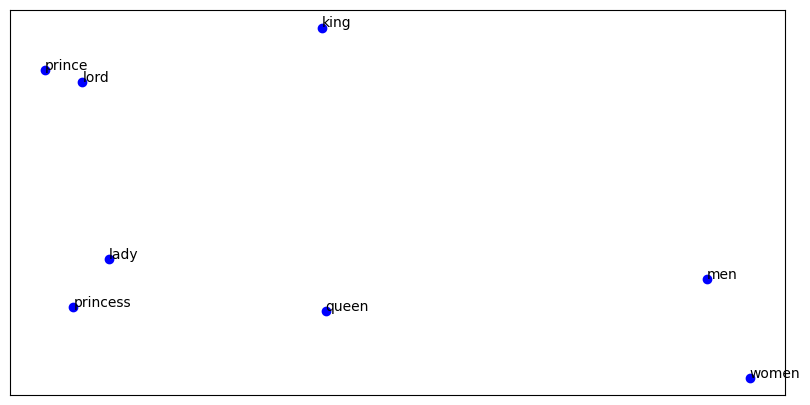

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
for word in ['king', 'queen', 'lord', 'lady', 'prince', 'princess', 'men', 'women']:
  point = Z[glove_vectors.get_index(word)]
  plt.scatter(point[0], point[1], color='b')
  plt.annotate(word, (point[0], point[1]))
  plt.xticks([])
  plt.yticks([])

We can see here that these word embeddings have captured gender related distinctions, as there is a trend of words with male connotations being at a greater value on the y axis than female connotated words. The X axis seems to effectively distinguish ranks of royalty, with equivalent ranks (queen/king, princess/prince, etc) being nearly in-line on the x-axis. Since the dominance of the words king and queen are different to that of prince or lady, they are spaced apart, and since lord and prince may evoke a similar sense of importance, they are spaced nearby. Words that have similar connotations of importance and gender will therefore be spaced closeby, implying they're related words by 2 metrics.



## F. Word Analogy: prince is to princess as lord is to? (10 points)
  - word1: `prince`, word2: `princess`, word3: `lord`
  - `direction = vec(word2) - vec(word1)`
  - `vec_tgt = vec(word3) + direction`
  - Calcuate the cosine similarities between `vec_tgt` and all the words in the vocabulary, **except for word3**.
  - Return the word that has the highest cosine similarity score.

In [48]:
def word_analogy(glove_vectors, word1, word2, word3):
    """
    Args:
        glove_vectors (Gensim KeyedVectors)
        word1 (str): The first word in the analogy.
        word2 (str): The second word in the analogy.
        word3 (str): The third word in the analogy for which to find the analogous word.

    Returns:
        pred_word (str): The word that best completes the analogy.
    """

    # Your code here

    vec1 = glove_vectors.get_vector(word1)
    vec2 = glove_vectors.get_vector(word2)
    vec3 = glove_vectors.get_vector(word3)
    direction = vec2 - vec1
    vec_tgt = vec3 + direction

    similarities = []

    for idx, word in enumerate(glove_vectors.index_to_key):
        if word == word3:
            continue

        word_vec = glove_vectors.get_vector(word)

        norm_vectgt = np.sum(vec_tgt ** 2) ** 0.5
        norm_wordvec = np.sum(word_vec ** 2) ** 0.5

        cos = np.dot(vec_tgt, word_vec) / ((norm_vectgt) * (norm_wordvec))

        similarities.append((word, cos))

    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    pred_word = similarities[0][0]

    print(f'{word1} is to {word2} as {word3} is to? {pred_word}')
    assert pred_word != word3
    return pred_word

In [49]:
pred_word = word_analogy(glove_vectors, 'prince', 'princess', 'lord')
pred_word = word_analogy(glove_vectors, 'aunt', 'uncle', 'queen')
pred_word = word_analogy(glove_vectors, 'london', 'england', 'paris')
pred_word = word_analogy(glove_vectors, 'cat', 'cats', 'car')

prince is to princess as lord is to? lady
aunt is to uncle as queen is to? king
london is to england as paris is to? france
cat is to cats as car is to? cars
